(example-recursive)=
# Recursive netlists

In this tutorial, we are replicating the previous tutorial, 
[Add-drop filters](./filters.ipynb), but using the more sensible "recursive 
netlist" method to define the whole circuit.

## Introduction to recursive netlists

We know now that a netlist is simply a dictionary with four special named keys:
``"instances"``, ``"connections"``, ``"ports"``, and (optionally), 
``"placements"``. Well, a recursive netlist is simply a dictionary of netlists--named keys to netlist dictionaries.
Each nested netlist in the dictionary may contain within its "instances" key some other named netlist.

As an example, suppose we had the simple circuit of two waveguides connected sequentially, like so:

In [1]:
some_subcircuit = {
    "instances": {
        # define model names
        "wg1": "long_waveguide",
        "wg2": "short_waveguide",
        
        # or define model names with  model settings (parameters to fill in)
        # "wg1": {"component": "long_waveguide", "settings": {"length": 10}, "info": {}},
        # "wg2": {"component": "short_waveguide", "settings": {"length": 5}, "info": {}},
    },
    "connections": {
        'wg1,o1': 'wg2,o0'
    },
    "ports": {
        "in": "wg1,o0",
        "out": "wg2,o1",
    },
}

A recursive netlist then simply has one toplevel circuit with instances that reference other netlists. The topleve is automatically determined, and does not need to be explicitly specified; it's simply the last remaining circuit after all other circuits have been nested appropriately. For example, we could create a circuit that uses the subcircuit we defined above, cascading three of them in series:

In [2]:
# a recursive netlist has one toplevel that references other netlists
recnet = {
    "my_toplevel_circuit": {
        "instances": {
            # define model names
            "suba": "sub1",
            "subb": "sub2",
            "subc": "sub3",

            # or define model names with model settings
            # "sub1": {"component": "sub1", "settings": {}, "info": {}},
            # "sub2": {"component": "sub2", "settings": {}, "info": {}},
            # "sub3": {"component": "sub3", "settings": {}, "info": {}},
        },
        "connections": {
            "suba,out": "subb,in",
            "subb,out": "subc,in",
        },
        "ports": {
            "in": "suba,in",
            "out": "subc,out",
        },
    },
    "sub1": some_subcircuit,
    "sub2": some_subcircuit,
    "sub3": some_subcircuit,
}

Our recursive netlist is now represented like so:

In [3]:
recnet

{'my_toplevel_circuit': {'instances': {'suba': 'sub1',
   'subb': 'sub2',
   'subc': 'sub3'},
  'connections': {'suba,out': 'subb,in', 'subb,out': 'subc,in'},
  'ports': {'in': 'suba,in', 'out': 'subc,out'}},
 'sub1': {'instances': {'wg1': 'long_waveguide', 'wg2': 'short_waveguide'},
  'connections': {'wg1,o1': 'wg2,o0'},
  'ports': {'in': 'wg1,o0', 'out': 'wg2,o1'}},
 'sub2': {'instances': {'wg1': 'long_waveguide', 'wg2': 'short_waveguide'},
  'connections': {'wg1,o1': 'wg2,o0'},
  'ports': {'in': 'wg1,o0', 'out': 'wg2,o1'}},
 'sub3': {'instances': {'wg1': 'long_waveguide', 'wg2': 'short_waveguide'},
  'connections': {'wg1,o1': 'wg2,o0'},
  'ports': {'in': 'wg1,o0', 'out': 'wg2,o1'}}}

In order to solve the circuit, we have to solve ``"some_subcircuit"``. In order to solve ``"some_subcircuit"``, we need to solve ``"long_waveguide"`` and ``"short_waveguide"`` first. Hence, we can see what the "lowest level" models that our circuit depends on. These must be defined for the circuit to be able to solve.

SAX makes it easy for us to determine which models are dependencies of the circuit. We can use the built in tools to create a directed acyclic graph (DAG) of the circuit. First, we'll parse our dictionary netlist into a SAX-native object:

In [4]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sax


netlist = sax.RecursiveNetlist.parse_obj(recnet)

And then create our dependency graph:

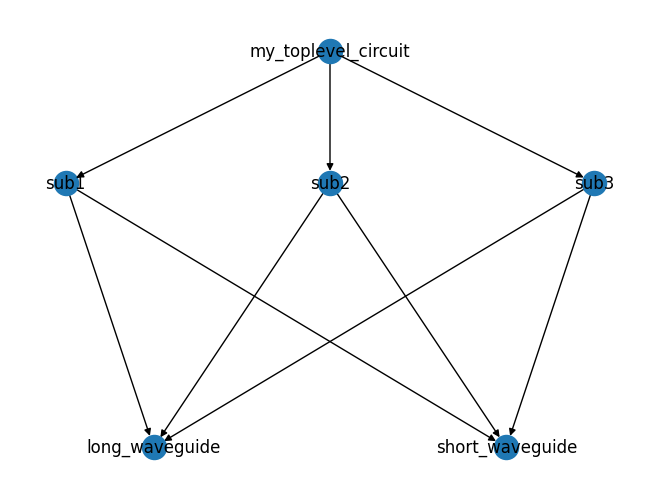

In [5]:
from sax.circuit import _create_dag, _draw_dag


_draw_dag(_create_dag(netlist))

We see that the entire recursive circuit depends on just two models: ``"long_waveguide"`` and ``"short_waveguide"``. We can now define these models, and then solve the circuit.

## Recreating the rings subcircuit

We now create the netlist, or subcircuit, that defines a ring resonator for us. We won't define any of its parameters yet, allowing the overall model to remain parameterizable.

In [7]:
# Create a netlist for a full ring (with terminator) from half rings.
# Resulting pin names are ('through', 'drop', 'in', 'out').
ring_netlist = {
    "instances": {
        "ring1": "half_ring",
        "ring2": "half_ring",
    },
    "connections": {
        "ring1,o1": "ring2,o3",
        "ring2,o1": "ring1,o3",
    },
    "ports": {
        "in": "ring1,o0",
        "through": "ring1,o2",
        "drop": "ring2,o2",
        "add": "ring2,o0",
    }
}

We can now use our netlist inside of a larger netlist (note that the use of the name "toplevel" is not a requirement, but it does make sense semantically):

In [8]:
recursive_rings_netlist = {
    "toplevel": {
        "instances": {
            "ring1": "ring",
            "ring2": "ring",
            "ring3": "ring",
        },
        "connections": {
            "ring1,through": "ring2,in",
            "ring2,through": "ring3,in",
        },
        "ports": {
            "in": "ring1,in",
            "out1": "ring1,drop",
            "out2": "ring2,drop",
            "out3": "ring3,drop",
        },
    },
    "ring": ring_netlist,
}

We're going to need a model for the most base-level component in our netlist: the half-ring.

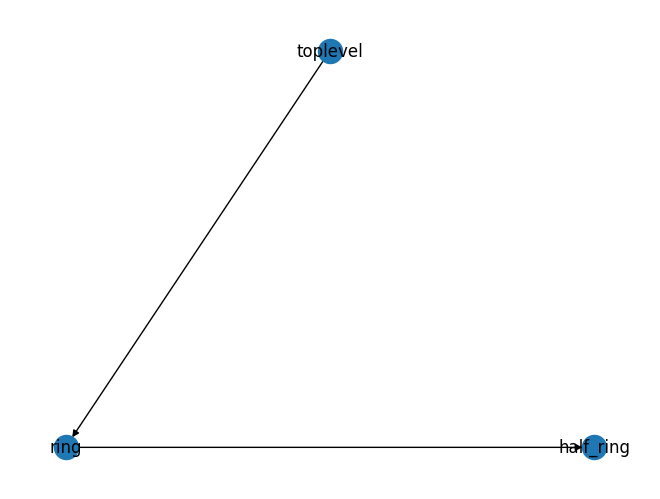

In [9]:
netlist = sax.RecursiveNetlist.parse_obj(recursive_rings_netlist)
_draw_dag(_create_dag(netlist))

I will use the ``partial`` function to fill out defeault parameters, while still leaving a few others (like the radius) to be defined later.

```{note} 

The ``partial`` function is a Python function that allows you to create a new function from an existing function, but with some parameters already filled in. In this case, we are creating a new function that takes only the radius as a parameter, and returns a ring resonator with that radius. This is useful because we can set new default parameters for arguments of the new function, and we can pass the new function around as a parameter to other functions. This is a very powerful tool in Python, and we will use it often in simulations.
```

In [10]:
from functools import partial
from simphony.libraries import sipann


half_ring = partial(sipann.half_ring, width=500, thickness=220, gap=100)

We can now create an actual circuit from our netlist. The statement is much
more succinct:

In [11]:
mzi, info = sax.circuit(
    netlist=netlist,
    models={"half_ring": half_ring}
)

We can also examine the nested parameters the circuit takes. Remember that we can defined parameters at various "depths" and the names will be applied globally from that level down to all components that accept the given keyword parameter.

In [12]:
sax.get_settings(mzi)

{'ring1': {'ring1': {'wl': Array(1.55, dtype=float64),
   'width': Array(500., dtype=float64),
   'thickness': Array(220., dtype=float64),
   'radius': Array(10., dtype=float64),
   'gap': Array(100., dtype=float64),
   'sw_angle': Array(90., dtype=float64)},
  'ring2': {'wl': Array(1.55, dtype=float64),
   'width': Array(500., dtype=float64),
   'thickness': Array(220., dtype=float64),
   'radius': Array(10., dtype=float64),
   'gap': Array(100., dtype=float64),
   'sw_angle': Array(90., dtype=float64)}},
 'ring2': {'ring1': {'wl': Array(1.55, dtype=float64),
   'width': Array(500., dtype=float64),
   'thickness': Array(220., dtype=float64),
   'radius': Array(10., dtype=float64),
   'gap': Array(100., dtype=float64),
   'sw_angle': Array(90., dtype=float64)},
  'ring2': {'wl': Array(1.55, dtype=float64),
   'width': Array(500., dtype=float64),
   'thickness': Array(220., dtype=float64),
   'radius': Array(10., dtype=float64),
   'gap': Array(100., dtype=float64),
   'sw_angle': Array

## Simulation

We'll run a sweep simulation, but we're reducing the frequency range to 1524.5-1551.15 nm as we have done previously. This will show us a simpler graph of only a few peaks that the filter picks out.

Notice that I define ``radius`` for ``ring1``, ``ring2``, and ``ring3``. Even though there is no model there that directly represents a ``ring``; instead, the ``radius`` parameter will trickle down to the ``half_ring`` models that make up the ``ring`` netlists.

In [13]:
wl = jnp.linspace(1.5245, 1.55115, 1000)

S = mzi(wl=wl, ring1={"radius": 10}, ring2={"radius": 11}, ring3={"radius": 12})

Let's plot the three outputs. There is one point where all the peaks will overlap; we're going to pull this out into a separate plot on the side.

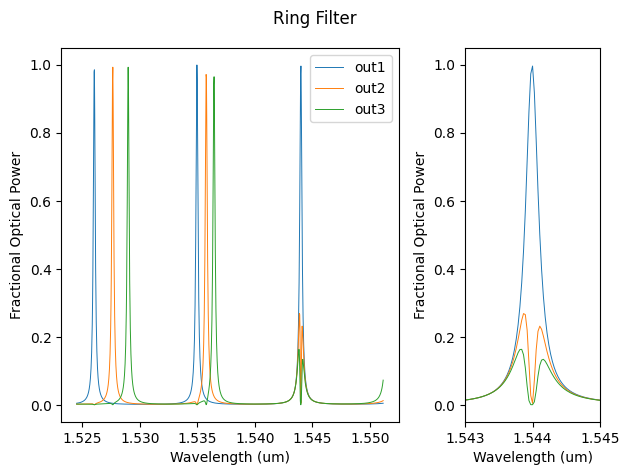

In [14]:
import matplotlib.gridspec as gridspec


fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(1, 3)

# Plot the three outputs over the full simulated wavelength range.
ax = fig.add_subplot(gs[0, :2])
ax.plot(wl, jnp.abs(S['in', 'out1'])**2, label="out1", lw=0.7)
ax.plot(wl, jnp.abs(S['in', 'out2'])**2, label="out2", lw=0.7)
ax.plot(wl, jnp.abs(S['in', 'out3'])**2, label="out3", lw=0.7)
ax.set_ylabel("Fractional Optical Power")
ax.set_xlabel("Wavelength (um)")
ax.legend(loc="upper right")

# Plot the three outputs over a restricted wavelength range.
ax = fig.add_subplot(gs[0, 2])
ax.plot(wl, jnp.abs(S['in', 'out1'])**2, label="out1", lw=0.7)
ax.plot(wl, jnp.abs(S['in', 'out2'])**2, label="out2", lw=0.7)
ax.plot(wl, jnp.abs(S['in', 'out3'])**2, label="out3", lw=0.7)
ax.set_xlim(1.543, 1.545)
ax.set_ylabel("Fractional Optical Power")
ax.set_xlabel("Wavelength (um)")

plt.suptitle("Ring Filter")
fig.align_labels()
plt.show()

*The response of our designed add-drop filter.*

Our result matches the previous tutorial.